Name: Albright Maduka Ifechukwude

Student Id: 9053136

Course code: PROG8431

Project Context: Nitrogen vs Soil pH (Canada Agriculture)

Course: Data Analysis Mathematics and Algorithm Model

1. Import the Libraries

In [30]:
import sys, platform, os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Iterable, Tuple, Optional, Dict, List
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Environment: {'python': '3.13.9', 'platform': 'Windows 11', 'pandas': '2.3.3', 'numpy': '2.3.4', 'matplotlib': '3.10.7'}
Using provided DataFrame.
         Name Fertility       Photoperiod  Temperature    Rainfall        pH  \
0  Strawberry  Moderate       Day Neutral    20.887923  747.860765  6.571548   
1  Strawberry  Moderate       Day Neutral    18.062721  711.104329  6.251806   
2  Strawberry  Moderate  Short Day Period    16.776782  774.038247  6.346916   
3  Strawberry  Moderate  Short Day Period    14.281000  665.633506  6.259598   
4  Strawberry  Moderate       Day Neutral    21.444490  806.531455  6.384368   

   Light_Hours  Light_Intensity         Rh    Nitrogen  Phosphorus  \
0    13.091483       533.762876  91.197196  170.800381  118.670058   
1    13.063016       505.789101  91.939623  179.290364  121.020244   
2    12.945927       512.985617  91.387286  181.440732  116.936806   
3    13.318922       484.860067  91.254598  176.165282  122.233153   
4    13.312915       5

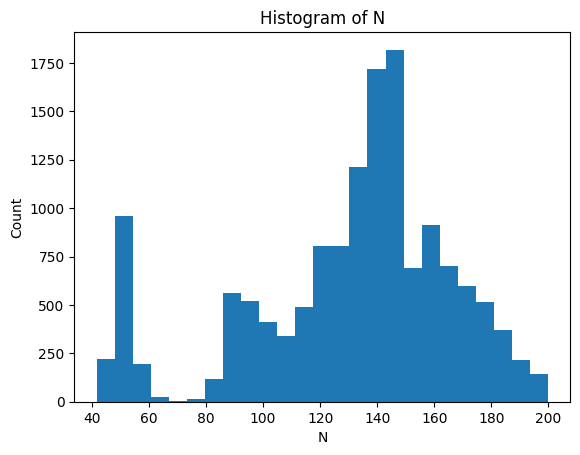

C:\Users\maduk\AppData\Local\Temp\ipykernel_22500\1342480379.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(self.df2[col], labels=[col])


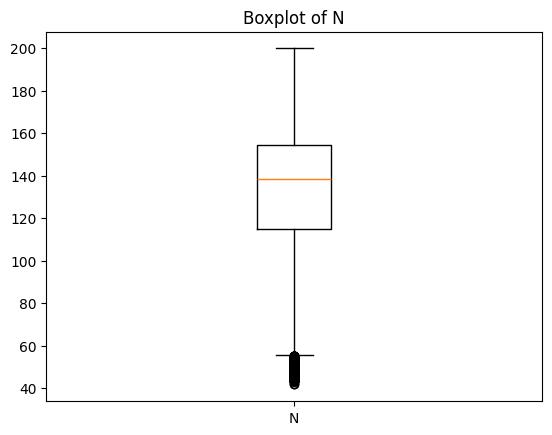

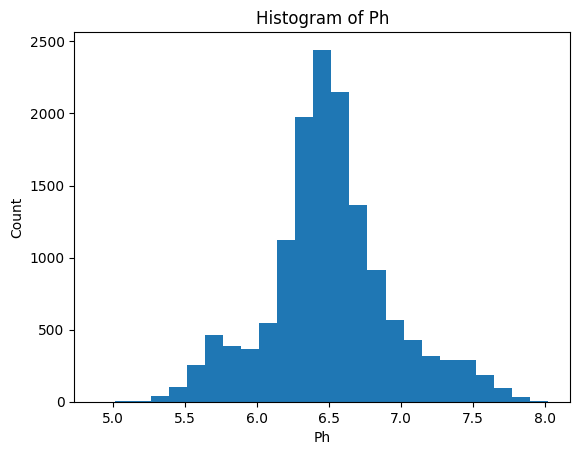

C:\Users\maduk\AppData\Local\Temp\ipykernel_22500\1342480379.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(self.df2[col], labels=[col])


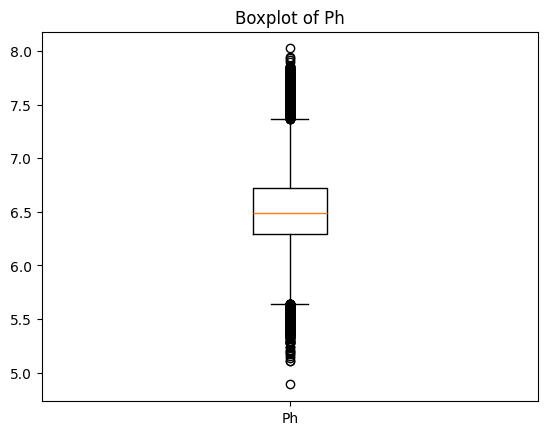

Clustering groups soil samples by nitrogen and pH similarity without labels. It reveals patterns like high nitrogen with lower pH, signalling acidification risk. These insights guide lime application and fertilizer optimization, improving soil health and sustainability by identifying stable regions and zones that require targeted monitoring.
Inertia: [16762.42584943736, 11498.853896634912, 8118.448979040391, 5703.238167144615, 4368.2178560978]
Silhouette: [0.36849725951055556, 0.3626272794611974, 0.39780941068946724, 0.4223351438474671, 0.42791927713339833]
Best k (silhouette): 6


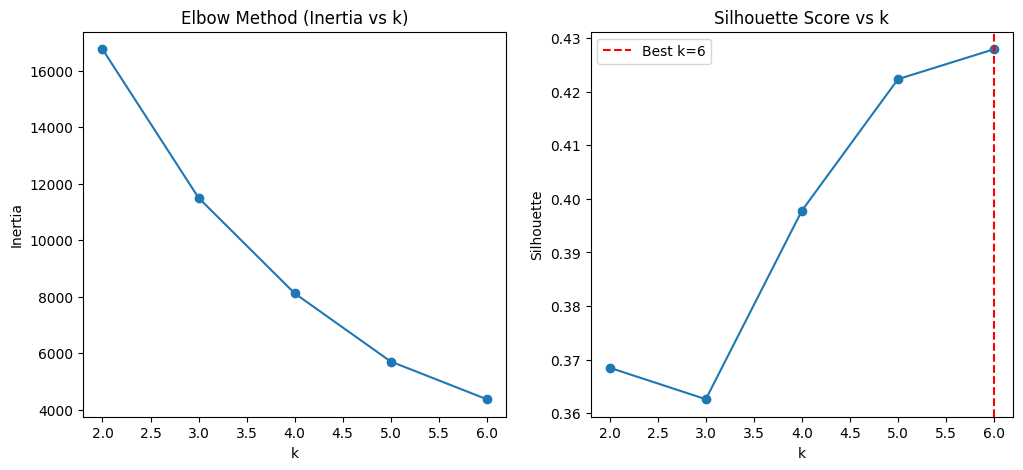

Cluster centers (original units):
      N_center  Ph_center
0  152.020070   6.326306
1  100.746537   6.471238
2  133.311688   6.730542
3  170.185104   5.711608
4  156.404457   7.450661
5   50.829692   6.965430


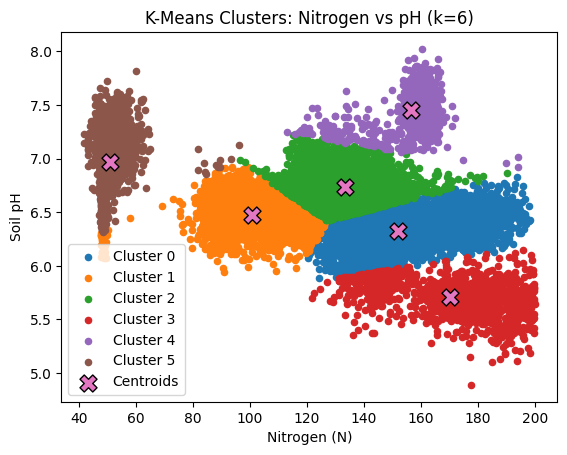

Cluster summary:
    cluster      N_mean   Ph_mean       N_min       N_max    Ph_min    Ph_max  \
0        0  152.025351  6.326775  120.298715  198.174579  5.883160  6.827241   
1        1  100.686389  6.470985   47.661961  126.595605  5.940265  6.920384   
2        2  133.282231  6.730552   96.438726  190.048065  6.426594  7.219058   
3        3  170.112302  5.712255  121.685457  199.858890  4.888871  6.147280   
4        4  156.404457  7.450661  112.821660  193.908347  6.917848  8.023210   
5        5   50.832973  6.966376   41.725552   96.279626  6.319720  7.814507   

   count  
0   4859  
1   2588  
2   3258  
3   1440  
4    834  
5   1369  
Saved: Clustered_Soil_Data.csv, Cluster_Centers.csv


In [31]:
@dataclass
class SoilClusteringProject:

    # Accept either a loaded DataFrame (df) OR a CSV path (csv_path)
    df: Optional[pd.DataFrame] = None
    csv_path: Optional[str] = None
    # internal artifacts
    df2: Optional[pd.DataFrame] = field(default=None, init=False)
    scaler: Optional[StandardScaler] = field(default=None, init=False)
    X_scaled: Optional[np.ndarray] = field(default=None, init=False)
    best_k: Optional[int] = field(default=None, init=False)
    kmeans: Optional[KMeans] = field(default=None, init=False)
    centers_: Optional[np.ndarray] = field(default=None, init=False)  # in original units

    # -------- 1) Technical readiness --------
    def inspect_env(self) -> Dict[str,str]:
        info = {
            "python": sys.version.split()[0],
            "platform": f"{platform.system()} {platform.release()}",
            "pandas": pd.__version__,
            "numpy": np.__version__,
            "matplotlib": plt.matplotlib.__version__,
        }
        print("Environment:", info)
        return info

    # -------- 2) Load + preview --------
    def load(self) -> pd.DataFrame:
        if self.df is not None:
            print("Using provided DataFrame.")
            return self.df
        if not self.csv_path or not os.path.exists(self.csv_path):
            raise FileNotFoundError("CSV path not provided or file not found.")
        self.df = pd.read_csv(self.csv_path)
        print(f"Loaded: {self.csv_path} | Rows: {len(self.df)} | Columns: {list(self.df.columns)}")
        return self.df

    def preview(self, n: int = 5) -> pd.DataFrame:
        if self.df is None:
            raise ValueError("Data not loaded yet.")
        print(self.df.head(n))
        return self.df.head(n)

    # -------- 3) Cleaning & feature selection (N, pH) --------
    def _norm(self, s: str) -> str:
        return re.sub(r'[^a-z0-9]+','', s.lower())

    def _detect_columns(self) -> Tuple[str, str]:
        assert self.df is not None, "Load data first."
        cols = list(self.df.columns)
        norm = {c: self._norm(c) for c in cols}
        cand_n  = [c for c in cols if norm[c] in {"n","nitrogen","nrate","nitrogenrate"} or "nitrogen" in norm[c]]
        cand_ph = [c for c in cols if norm[c] == "ph" or "ph" in norm[c]]
        if not cand_n or not cand_ph:
            raise KeyError(f"Could not detect N/pH columns. Found: {cols}")
        cand_n.sort(key=lambda s: (len(s), s.lower()))
        cand_ph.sort(key=lambda s: (len(s), s.lower()))
        return cand_n[0], cand_ph[0]

    def clean_and_select(self,
                         n_bounds: Tuple[float,float]=(0,200),
                         ph_bounds: Tuple[float,float]=(2.5,9.5)
                         ) -> pd.DataFrame:
        assert self.df is not None, "Load data first."
        n_col, ph_col = self._detect_columns()

        df2 = self.df[[n_col, ph_col]].copy()
        df2.columns = ["N", "Ph"]

        # robust numeric coercion (handles commas/units)
        for c in ["N","Ph"]:
            s = (df2[c].astype(str)
                        .str.replace(",", "", regex=False)
                        .str.replace(r"[^\d\.\-\+eE]+","", regex=True))
            df2[c] = pd.to_numeric(s, errors="coerce")

        # drop missing and apply bounds
        df2 = df2.dropna(subset=["N","Ph"])
        df2 = df2[df2["N"].between(*n_bounds)]
        df2 = df2[df2["Ph"].between(*ph_bounds)]

        self.df2 = df2.reset_index(drop=True)
        print("Cleaned data summary:\n", self.df2.describe())
        return self.df2

    # -------- 4) EDA --------
    def plot_distributions(self) -> None:
        assert self.df2 is not None, "Run clean_and_select() first."
        for col in ["N","Ph"]:
            plt.figure()
            plt.hist(self.df2[col], bins=25)
            plt.title(f"Histogram of {col}")
            plt.xlabel(col); plt.ylabel("Count")
            plt.show()

            plt.figure()
            plt.boxplot(self.df2[col], labels=[col])
            plt.title(f"Boxplot of {col}")
            plt.show()

    # -------- 5) Concept (rubric text) --------
    def clustering_concept_50_words(self) -> str:
        text = (
             "Clustering groups soil samples by nitrogen and pH similarity without labels. "
        "It reveals patterns like high nitrogen with lower pH, signalling acidification risk. "
        "These insights guide lime application and fertilizer optimization, improving soil health "
        "and sustainability by identifying stable regions and zones that require targeted monitoring."
        )
        print(text)
        return text

    # -------- 6) Scaling --------
    def scale_features(self) -> np.ndarray:
        assert self.df2 is not None, "Run clean_and_select() first."
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.df2[["N","Ph"]].to_numpy())
        return self.X_scaled

    # -------- 7) Model selection (Elbow + Silhouette) --------
    def find_best_k(self, k_range: Iterable[int] = range(2,7)) -> Tuple[int, List[float], List[float]]:
        assert self.X_scaled is not None, "Run scale_features() first."
        inertias, sils = [], []
        ks = list(k_range)
        for k in ks:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(self.X_scaled)
            inertias.append(km.inertia_)
            sils.append(silhouette_score(self.X_scaled, labels))

        self.best_k = ks[int(np.argmax(sils))]
        print("Inertia:", inertias)
        print("Silhouette:", sils)
        print("Best k (silhouette):", self.best_k)

        # plots
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(ks, inertias, marker='o')
        plt.title("Elbow Method (Inertia vs k)")
        plt.xlabel("k"); plt.ylabel("Inertia")

        plt.subplot(1,2,2)
        plt.plot(ks, sils, marker='o')
        plt.axvline(self.best_k, color='red', linestyle='--', label=f'Best k={self.best_k}')
        plt.title("Silhouette Score vs k")
        plt.xlabel("k"); plt.ylabel("Silhouette")
        plt.legend()
        plt.show()

        return self.best_k, inertias, sils

    # -------- 8) Modeling --------
    def fit_kmeans(self, k: Optional[int] = None) -> np.ndarray:
        assert self.X_scaled is not None, "Run scale_features() first."
        k = k or self.best_k or 2
        self.kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = self.kmeans.fit_predict(self.X_scaled)
        self.df2 = self.df2.copy()
        self.df2["cluster"] = labels
        # back-transform centers to original units
        centers_scaled = self.kmeans.cluster_centers_
        self.centers_ = self.scaler.inverse_transform(centers_scaled)
        print("Cluster centers (original units):\n", pd.DataFrame(self.centers_, columns=["N_center","Ph_center"]))
        return self.centers_

    # -------- 9) Visualization --------
    def plot_clusters(self) -> None:
        assert self.kmeans is not None and self.centers_ is not None, "Run fit_kmeans() first."
        k = self.kmeans.n_clusters
        plt.figure()
        for cl in range(k):
            mask = self.df2["cluster"] == cl
            plt.scatter(self.df2.loc[mask, "N"], self.df2.loc[mask, "Ph"], s=20, label=f"Cluster {cl}")
        plt.scatter(self.centers_[:,0], self.centers_[:,1], marker='X', s=150, edgecolor='k', label="Centroids")
        plt.xlabel("Nitrogen (N)")
        plt.ylabel("Soil pH")
        plt.title(f"K-Means Clusters: Nitrogen vs pH (k={k})")
        plt.legend()
        plt.show()

    # -------- 10) Interpretation --------
    def summarize_clusters(self) -> pd.DataFrame:
        assert self.df2 is not None and "cluster" in self.df2.columns, "Run fit_kmeans() first."
        summary = self.df2.groupby("cluster").agg(
            N_mean=("N","mean"),
            Ph_mean=("Ph","mean"),
            N_min=("N","min"),
            N_max=("N","max"),
            Ph_min=("Ph","min"),
            Ph_max=("Ph","max"),
            count=("cluster","size")
        ).reset_index()
        print("Cluster summary:\n", summary)
        return summary

    # -------- 11) Save outputs (reproducibility) --------
    def save_outputs(self,
                     data_path: str="Clustered_Soil_Data.csv",
                     centers_path: str="Cluster_Centers.csv") -> None:
        assert self.df2 is not None and self.centers_ is not None, "Run fit_kmeans() first."
        self.df2.to_csv(data_path, index=False)
        pd.DataFrame(self.centers_, columns=["N_center","Ph_center"]).to_csv(centers_path, index=False)
        print(f"Saved: {data_path}, {centers_path}")


try:
    project = SoilClusteringProject(df=df) 
except NameError:
    project = SoilClusteringProject(csv_path="Soil Nutrients.csv")

project.inspect_env()
project.load()
project.preview(5)
project.clean_and_select(n_bounds=(0,200), ph_bounds=(2.5,9.5))
project.plot_distributions()
project.clustering_concept_50_words()
project.scale_features()
project.find_best_k(range(2,7))
project.fit_kmeans()        # uses best_k found (fallback=2)
project.plot_clusters()
project.summarize_clusters()
project.save_outputs()
